In [1]:
!pip3 install -U setuptools==65.5.0 pip==21
!pip3 install gymnasium
!pip3 install skrl
!pip3 install stable_baselines3
!pip3 install imitation
!pip3 install highway-env

  Using cached setuptools-65.5.0-py3-none-any.whl (1.2 MB)
  Using cached pip-21.0-py3-none-any.whl (1.5 MB)
You should consider upgrading via the '/Users/khoavo2003/anaconda3/envs/cr37/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/khoavo2003/anaconda3/envs/cr37/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/khoavo2003/anaconda3/envs/cr37/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/khoavo2003/anaconda3/envs/cr37/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/khoavo2003/anaconda3/envs/cr37/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/khoavo2003/anaconda3/envs/cr37/bin/python3 -m pip install --upgrade pip' command.


# Import library

In [11]:
import gymnasium as gym
import highway_env
import torch
import numpy as np
# import the skrl components to build the RL system
from skrl.agents.torch.dqn import DDQN, DDQN_DEFAULT_CONFIG
from skrl.envs.wrappers.torch import wrap_env
from skrl.memories.torch import RandomMemory
from skrl.trainers.torch import SequentialTrainer
from skrl.utils import set_seed
from skrl.utils.model_instantiators.torch import Shape, deterministic_model
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ppo import MlpPolicy

from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
import gymnasium as gym
import highway_env
from imitation.algorithms import bc
from imitation.algorithms.dagger import SimpleDAggerTrainer
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from gymnasium.wrappers.monitoring import video_recorder
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

from skrl.trainers.torch import ParallelTrainer
import warnings
import os
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/5.1/bin/ffmpeg"
import gymnasium as gym

import torch.nn as nn
import torch.nn.functional as F

# import the skrl components to build the RL system
from skrl.agents.torch.cem import CEM, CEM_DEFAULT_CONFIG
from skrl.envs.wrappers.torch import wrap_env
from skrl.memories.torch import RandomMemory
from skrl.models.torch import CategoricalMixin, Model
from skrl.trainers.torch import SequentialTrainer
from skrl.utils import set_seed



# Config


In [12]:
environment_name = 'highway-v0'

The environment is used is highway-v0, which I showed on the slide

In [13]:
# seed for reproducibility
set_seed()  # e.g. `set_seed(42)` for fixed seed


# define model (categorical model) using mixin
class Policy(CategoricalMixin, Model):
    def __init__(self, observation_space, action_space, device, unnormalized_log_prob=True):
        Model.__init__(self, observation_space, action_space, device)
        CategoricalMixin.__init__(self, unnormalized_log_prob)

        self.linear_layer_1 = nn.Linear(self.num_observations, 64)
        self.linear_layer_2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, self.num_actions)

    def compute(self, inputs, role):
        x = F.relu(self.linear_layer_1(inputs["states"]))
        x = F.relu(self.linear_layer_2(x))
        return self.output_layer(x), {}


# load and wrap the gymnasium environment.
# note: the environment version may change depending on the gymnasium version
env = gym.make(environment_name, render_mode = 'rgb_array')
env = wrap_env(env)

device = env.device


# instantiate a memory as experience replay
memory = RandomMemory(memory_size=1000, num_envs=env.num_envs, device=device, replacement=False)


# instantiate the agent's model (function approximator).
# CEM requires 1 model, visit its documentation for more details
# https://skrl.readthedocs.io/en/latest/api/agents/cem.html#models
models = {}
models["policy"] = Policy(env.observation_space, env.action_space, device)

# initialize models' parameters (weights and biases)
for model in models.values():
    model.init_parameters(method_name="normal_", mean=0.0, std=0.1)


# configure and instantiate the agent (visit its documentation to see all the options)
# https://skrl.readthedocs.io/en/latest/api/agents/cem.html#configuration-and-hyperparameters
cfg = CEM_DEFAULT_CONFIG.copy()
cfg["rollouts"] = 1000
cfg["learning_starts"] = 100
# logging to TensorBoard and write checkpoints (in timesteps)
cfg["experiment"]["write_interval"] = 1000
cfg["experiment"]["checkpoint_interval"] = 1000
cfg["experiment"]["directory"] = environment_name

agent = CEM(models=models,
            memory=memory,
            cfg=cfg,
            observation_space=env.observation_space,
            action_space=env.action_space,
            device=device)


[skrl:INFO] Seed: 2049615147
/Users/khoavo2003/anaconda3/envs/cr37/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
[skrl:INFO] Environment class: gymnasium.core.Wrapper, gymnasium.utils.record_constructor.RecordConstructorArgs
[skrl:INFO] Environment wrapper: Gymnasium


# Train example expert

In [15]:
# configure and instantiate the RL trainer
cfg_trainer = {"timesteps": 10000, "headless": False}
trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=[agent])

# start training
trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

 75%|███████▌  | 7531/10000 [41:29<13:36,  3.02it/s]  

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/khoavo2003/anaconda3/envs/cr37/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/m8/f4qfc7j527x_gzcp82ry99940000gn/T/ipykernel_90687/6060953.py", line 6, in <module>
    trainer.train()
  File "/Users/khoavo2003/anaconda3/envs/cr37/lib/python3.11/site-packages/skrl/trainers/torch/sequential.py", line 77, in train
    self.single_agent_train()
  File "/Users/khoavo2003/anaconda3/envs/cr37/lib/python3.11/site-packages/skrl/trainers/torch/base.py", line 175, in single_agent_train
    next_states, rewards, terminated, truncated, infos = self.env.step(actions)
                                                         ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/khoavo2003/anaconda3/envs/cr37/lib/python3.11/site-packages/skrl/envs/wrappers/torch/gymnasium_envs.py", line 124, in step
    observation, reward, terminated, truncated, info = se

Load checkpoint

In [ ]:
agent.load("CartPole/Experiment_1/23-09-28_13-21-19-369630_DDQN/checkpoints/agent_200000.pt")

# Visualize result

Result (loss, reward mean, ...)

In [24]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir='CartPole/Experiment_1/23-09-26_21-04-24-070438_DQN' --port 2007

Make video

In [16]:
from matplotlib import animation
import matplotlib.pyplot as plt

"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick

Open file in CLI with:
xgd-open <filelname>
"""
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

# Sample transition

In [17]:
# Initialize lists to store transitions
obs_list, acts_list, infos_list, next_obs_list, dones_list = [], [], [], [], []

In [20]:
obs, info = env.reset()
counter = 0
episode_len = 15000
frames = []

# Define the number of episodes to collect transitions
num_episodes = 1

while True:
    frames.append(env.unwrapped.render())
    action = agent.act(obs, 0, 1)[0]
    next_obs, rew, done, truncated, info = env.step(action)

    # Append transitions to the lists
    obs_list.append(obs)
    acts_list.append(action)
    infos_list.append(info)
    next_obs_list.append(next_obs)
    dones_list.append(done)

    # Update the current observation
    obs = next_obs

    if done or truncated:
        break
    counter = counter + 1

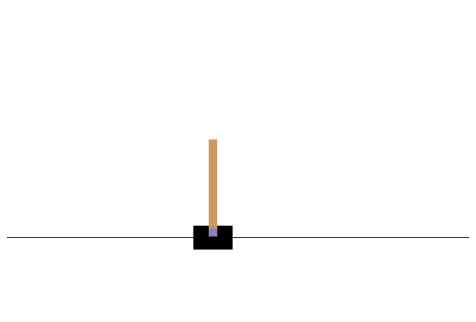

In [19]:
save_frames_as_gif(frames)

In [13]:
len(obs_list)

2500

In [14]:
# Create a dictionary to store the transitions
my_transitions = {
    "obs": obs_list,
    "acts": acts_list,
    "infos": infos_list,
    "next_obs": next_obs_list,
    "dones": dones_list
}

In [15]:
from imitation.data import types

def load_custom_transitions(my_transitions):
    transitions = types.Transitions(
        obs=np.array(my_transitions["obs"]),
        acts=np.array(my_transitions["acts"], dtype=np.int32),
        infos=my_transitions["infos"],
        next_obs=np.array(my_transitions["next_obs"]),
        dones=np.array(my_transitions["dones"], dtype=np.bool),
    )
    return transitions

# Load your custom transitions
custom_transitions = load_custom_transitions(my_transitions)

/var/folders/m8/f4qfc7j527x_gzcp82ry99940000gn/T/ipykernel_85855/522751877.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  obs=np.array(my_transitions["obs"]),
/var/folders/m8/f4qfc7j527x_gzcp82ry99940000gn/T/ipykernel_85855/522751877.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  obs=np.array(my_transitions["obs"]),
/var/folders/m8/f4qfc7j527x_gzcp82ry9994

# Behavior cloning

Make the new environment since the old environment is wrapped, thus cannot be use in this case

In [26]:
env1 = gym.make('CartPole-v1', render_mode = 'rgb_array')

In [27]:
rng = np.random.default_rng(0)
bc_trainer = bc.BC(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    demonstrations=custom_transitions,
    rng=rng,
)

In [28]:
reward, _ = evaluate_policy(
    bc_trainer.policy,  # type: ignore[arg-type]
    env1,
    n_eval_episodes=10,
)
print(f"Reward before training: {reward}")

Reward before training: 9.6


/Users/khoavo2003/anaconda3/envs/cr37/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [ ]:
print("Training a policy using Behavior Cloning")
bc_trainer.train(n_epochs=1)

In [30]:
reward, _ = evaluate_policy(
    bc_trainer.policy,  # type: ignore[arg-type]
    env1,
    n_eval_episodes=10,
)
print(f"Reward after training: {reward}")

Reward after training: 500.0


## Visualize result

In [67]:
obs, info = env.reset()
counter = 0
episode_len = 500
frames = []

# Define the number of episodes to collect transitions
num_episodes = 1

while True:
    frames.append(env.unwrapped.render())
    action = bc_trainer.policy.forward(obs)[0]
    next_obs, rew, done, truncated, info = env.step(action)

    # Update the current observation
    obs = next_obs

    if done or truncated:
        break
    counter = counter + 1

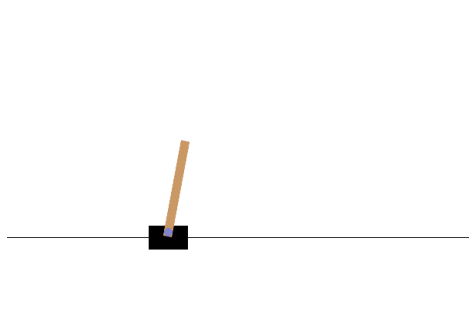

In [69]:
save_frames_as_gif(frames, filename='behavior_cloning.gif')

# Generative Adversarial Imitation Learning

In [34]:
env1 = make_vec_env(
    "CartPole-v1",
    rng=np.random.default_rng(42),
    n_envs=8,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],  # to compute rollouts
)

In [32]:
env1.observation_space.sample()

array([-2.6099651e+00,  2.8907567e+38,  2.9632330e-02, -1.5335073e+38],
      dtype=float32)

In [25]:
custom_transitions[0]

{'obs': tensor([[-0.0126,  0.0078, -0.0475,  0.0196]]),
 'acts': 1,
 'infos': {},
 'next_obs': tensor([[-0.0124,  0.2036, -0.0471, -0.2877]]),
 'dones': False}

In [ ]:
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy

# env1 = gym.make('CartPole-v1', render_mode = 'rgb_array')

learner = PPO(
    env=env1,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.00001,
    n_epochs=1,
    seed=42,
)
reward_net = BasicShapedRewardNet(
    observation_space=env1.observation_space,
    action_space=env1.action_space,
    normalize_input_layer=RunningNorm,
)
gail_trainer = GAIL(
    demonstrations=custom_transitions,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=env1,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=True
)

# evaluate the learner before training
env1.seed(42)
learner_rewards_before_training, _ = evaluate_policy(
    learner, env1, 100, return_episode_rewards=True
)

# train the learner and evaluate again
gail_trainer.train(20000)
env1.seed(42)
learner_rewards_after_training, _ = evaluate_policy(
    learner, env1, 100, return_episode_rewards=True
)

# Maximum entropy inverse reinforcement learning

In [1]:
from functools import partial

from seals import base_envs
from seals.diagnostics.cliff_world import CliffWorldEnv
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np

from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)
from imitation.data import rollout
from imitation.rewards import reward_nets

env_creator = partial(CliffWorldEnv, height=4, horizon=40, width=7, use_xy_obs=True)
env_single = env_creator()

state_env_creator = lambda: base_envs.ExposePOMDPStateWrapper(env_creator())

# This is just a vectorized environment because `generate_trajectories` expects one
state_venv = DummyVecEnv([state_env_creator] * 4)

In [2]:
_, _, pi = mce_partition_fh(env_single)

_, om = mce_occupancy_measures(env_single, pi=pi)

rng = np.random.default_rng()
expert = TabularPolicy(
    state_space=env_single.state_space,
    action_space=env_single.action_space,
    pi=pi,
    rng=rng,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
    rng=rng,
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

Expert stats:  {'n_traj': 128, 'return_min': 296.0, 'return_mean': 325.75, 'return_std': 8.379662881047185, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


In [3]:
import matplotlib.pyplot as plt
import torch as th


def train_mce_irl(demos, hidden_sizes, lr=0.01, **kwargs):
    reward_net = reward_nets.BasicRewardNet(
        env_single.observation_space,
        env_single.action_space,
        hid_sizes=hidden_sizes,
        use_action=False,
        use_done=False,
        use_next_state=False,
    )

    mce_irl = MCEIRL(
        demos,
        env_single,
        reward_net,
        log_interval=250,
        optimizer_kwargs=dict(lr=lr),
        rng=rng,
    )
    occ_measure = mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
        rng=rng,
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(occ_measure)
    plt.title("Occupancy for learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    _, true_occ_measure = mce_occupancy_measures(env_single)
    env_single.draw_value_vec(true_occ_measure)
    plt.title("Occupancy for true reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(
        reward_net(th.as_tensor(env_single.observation_matrix), None, None, None)
        .detach()
        .numpy()
    )
    plt.title("Learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    env_single.draw_value_vec(env_single.reward_matrix)
    plt.title("True reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    return mce_irl

--------------------------
| grad_norm   | 101      |
| iteration   | 0        |
| linf_delta  | 32.5     |
| weight_norm | 11.4     |
--------------------------
--------------------------
| grad_norm   | 0.336    |
| iteration   | 250      |
| linf_delta  | 0.2      |
| weight_norm | 17.4     |
--------------------------
--------------------------
| grad_norm   | 0.339    |
| iteration   | 500      |
| linf_delta  | 0.142    |
| weight_norm | 19.3     |
--------------------------
--------------------------
| grad_norm   | 0.313    |
| iteration   | 750      |
| linf_delta  | 0.066    |
| weight_norm | 21.9     |
--------------------------
Imitation stats:  {'n_traj': 128, 'return_min': 296.0, 'return_mean': 325.015625, 'return_std': 8.882905260069759, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


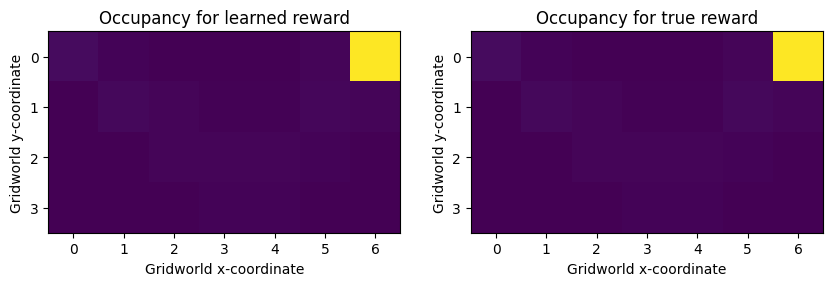

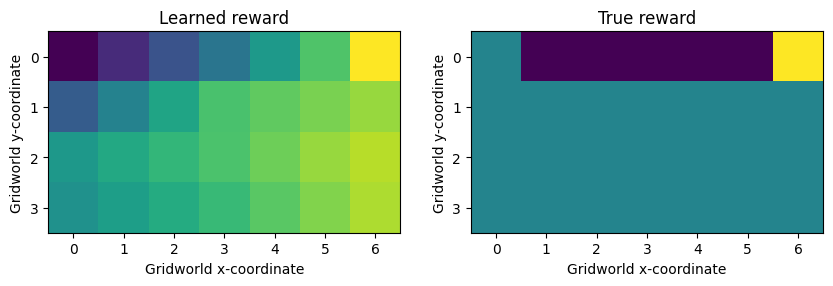

In [4]:
train_mce_irl(om, hidden_sizes=[256])

In [8]:
len(expert_trajs)

128

--------------------------
| grad_norm   | 126      |
| iteration   | 0        |
| linf_delta  | 33.3     |
| weight_norm | 11.2     |
--------------------------
--------------------------
| grad_norm   | 0.434    |
| iteration   | 250      |
| linf_delta  | 0.142    |
| weight_norm | 18       |
--------------------------
--------------------------
| grad_norm   | 0.583    |
| iteration   | 500      |
| linf_delta  | 0.106    |
| weight_norm | 21.8     |
--------------------------
--------------------------
| grad_norm   | 0.706    |
| iteration   | 750      |
| linf_delta  | 0.104    |
| weight_norm | 27.9     |
--------------------------
Imitation stats:  {'n_traj': 128, 'return_min': 289.0, 'return_mean': 324.46875, 'return_std': 8.979958153438133, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


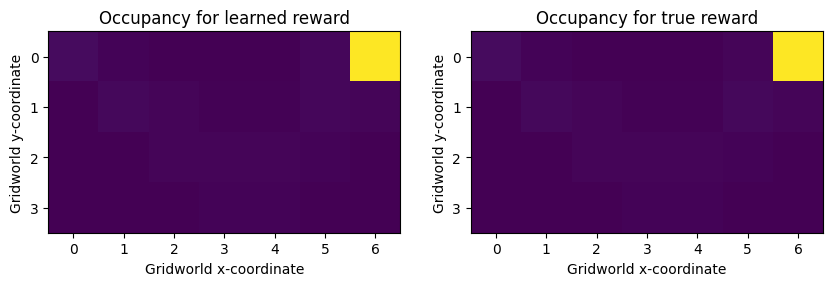

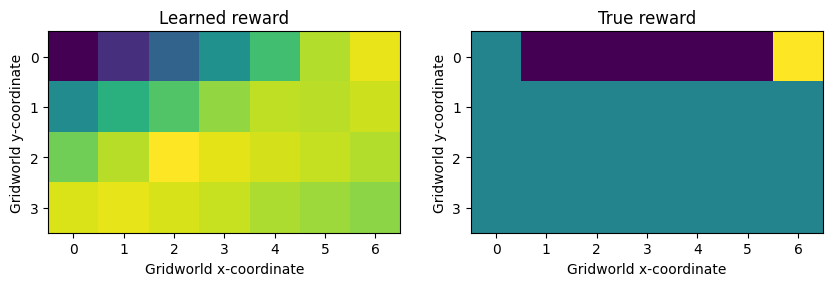

In [10]:
mce_irl_from_trajs = train_mce_irl(expert_trajs, hidden_sizes=[256])